<a href="https://colab.research.google.com/github/Gaurav-phatkare/Understanding_Amazon_From_Space-..Deep-learning/blob/main/Multi_label_Image_Classification_using_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Wed Aug 16 12:10:41 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv1D, Conv2D, Flatten, MaxPool2D, Dropout
from tensorflow.keras import Sequential

from tensorflow.keras import backend as K

In [3]:
!mkdir ~/.kaggle

In [4]:
!cp kaggle.json ~/.kaggle/

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

# Load Dataset

In [6]:
!kaggle datasets download -d nikitarom/planets-dataset

100% 1.50G/1.50G [01:22<00:00, 22.8MB/s]
100% 1.50G/1.50G [01:22<00:00, 19.4MB/s]


In [ ]:
!unzip /content/planets-dataset.zip

In [8]:
Train_path = "/content/planet/planet/train-jpg"
Test_path = "/content/planet/planet/test-jpg"

In [9]:
Train_csv_path = '/content/planet/planet/train_classes.csv'
Test_csv_path = "/content/planet/planet/sample_submission.csv"

In [10]:
df_train = pd.read_csv(Train_csv_path)
df_test = pd.read_csv(Test_csv_path)

In [11]:
df_train[:10]

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road
5,train_5,haze primary water
6,train_6,agriculture clear cultivation primary water
7,train_7,haze primary
8,train_8,agriculture clear cultivation primary
9,train_9,agriculture clear cultivation primary road


In [12]:
df_test[:10]

,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water
3,test_3,primary clear agriculture road water
4,test_4,primary clear agriculture road water
5,test_5,primary clear agriculture road water
6,test_6,primary clear agriculture road water
7,test_7,primary clear agriculture road water
8,test_8,primary clear agriculture road water
9,test_9,primary clear agriculture road water


**Check Whether entries from test_csv match with available images in test_folder**

In [13]:
for i, j, k in os.walk(Test_path):
    print(f"test images count: {len(k)}")

test images count: 40669


In [14]:
len(df_test)

61191

around 20k entries are extra in df_test

In [15]:
import re
def extract_digits(filename):
    digits = re.findall(r"\d+", filename)
    return int(digits[0]) if digits else 0


sorted_list = sorted(k, key = extract_digits)
sorted_list[-5:]

['test_40664.jpg',
 'test_40665.jpg',
 'test_40666.jpg',
 'test_40667.jpg',
 'test_40668.jpg']

In [16]:
df_test[-5:]

,image_name,tags
61186,file_9995,primary clear agriculture road water
61187,file_9996,primary clear agriculture road water
61188,file_9997,primary clear agriculture road water
61189,file_9998,primary clear agriculture road water
61190,file_9999,primary clear agriculture road water


files from the end are not same

In [17]:
df_test[:40672] # randomly slicing by taking number just greater than test images count

,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water
3,test_3,primary clear agriculture road water
4,test_4,primary clear agriculture road water
...,...,...
40667,test_40667,primary clear agriculture road water
40668,test_40668,primary clear agriculture road water
40669,file_0,primary clear agriculture road water
40670,file_1,primary clear agriculture road water


In [18]:
# entries from index 40669 are different

In [19]:
df_test = df_test[:40669]

In [20]:
df_test.tail()

,image_name,tags
40664,test_40664,primary clear agriculture road water
40665,test_40665,primary clear agriculture road water
40666,test_40666,primary clear agriculture road water
40667,test_40667,primary clear agriculture road water
40668,test_40668,primary clear agriculture road water


**Check the same with train folders and csv_file**

In [21]:
for i, j, k in os.walk(Train_path):
    print(f"train images count: {len(k)}")

train images count: 40479


In [22]:
len(df_train)

40479

In [23]:
import re
def extract_digits(filename):
    digits = re.findall(r"\d+", filename)
    return int(digits[0]) if digits else 0


sorted_list = sorted(k, key = extract_digits)
sorted_list[-5:]

['train_40474.jpg',
 'train_40475.jpg',
 'train_40476.jpg',
 'train_40477.jpg',
 'train_40478.jpg']

In [24]:
df_train[-5:]

,image_name,tags
40474,train_40474,clear primary
40475,train_40475,cloudy
40476,train_40476,agriculture clear primary
40477,train_40477,agriculture clear primary road
40478,train_40478,agriculture cultivation partly_cloudy primary


In [25]:
# in training set count are files are accurate

#Data Preprocessing

In [26]:
df_train['image_name'] = df_train['image_name'].astype(str) + '.jpg'
df_test['image_name'] = df_test['image_name'].astype(str) + '.jpg'

df_test['tags'] = df_test['tags'].apply(lambda x: x.split(" "))

In [27]:
df_test[-5:]

,image_name,tags
40664,test_40664.jpg,"[primary, clear, agriculture, road, water]"
40665,test_40665.jpg,"[primary, clear, agriculture, road, water]"
40666,test_40666.jpg,"[primary, clear, agriculture, road, water]"
40667,test_40667.jpg,"[primary, clear, agriculture, road, water]"
40668,test_40668.jpg,"[primary, clear, agriculture, road, water]"


In [28]:
X_train_files = np.array(df_train['image_name'].tolist())
print(X_train_files.shape[0])

40479


In [29]:
X_train_files[:5]

array(['train_0.jpg', 'train_1.jpg', 'train_2.jpg', 'train_3.jpg',
       'train_4.jpg'], dtype='<U15')

In [30]:
X_train_files.reshape((X_train_files.shape[0], 1))

array([['train_0.jpg'],
       ['train_1.jpg'],
       ['train_2.jpg'],
       ...,
       ['train_40476.jpg'],
       ['train_40477.jpg'],
       ['train_40478.jpg']], dtype='<U15')

In [31]:
y_train_labels = np.array(df_train['tags'].tolist())

## Unique labels list

In [32]:
labels = []

for tag in df_train['tags'].values:
    labels_in_tag = tag.split(" ")
    for label in labels_in_tag:
        if label not in labels:
            labels.append(label)
labels.sort()
print(labels)
labels_len = len(labels)
labels_len

['agriculture', 'artisinal_mine', 'bare_ground', 'blooming', 'blow_down', 'clear', 'cloudy', 'conventional_mine', 'cultivation', 'habitation', 'haze', 'partly_cloudy', 'primary', 'road', 'selective_logging', 'slash_burn', 'water']


17

#Visualize the image data with different resolutions

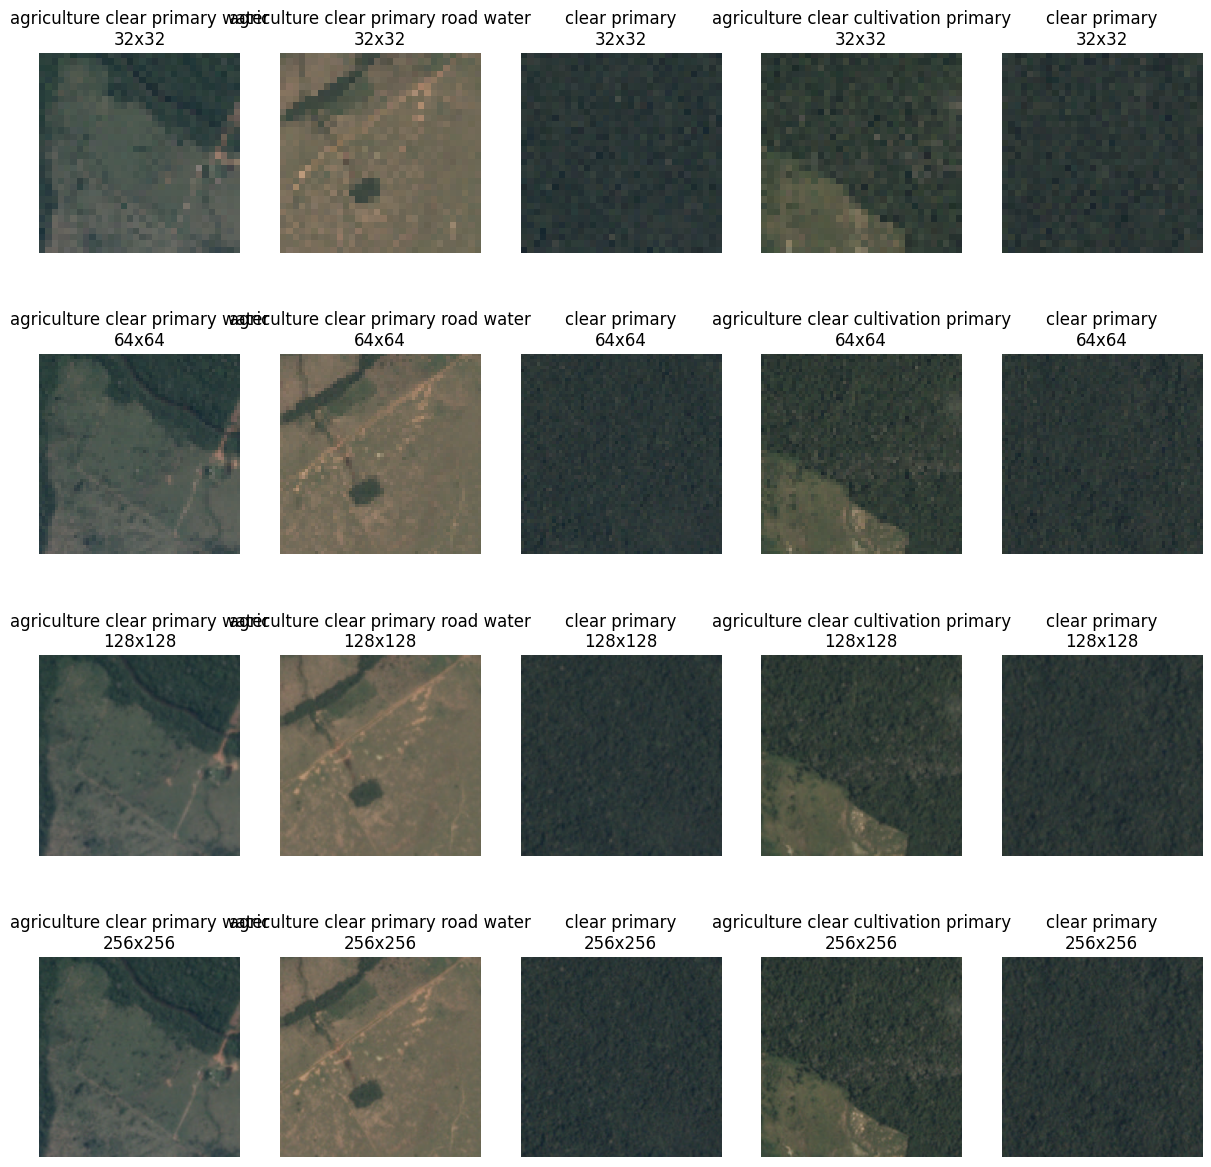

In [33]:
import random
rand_int = random.randint(0,10000)

plt.figure(figsize = (15, 15))

res = [32,64,128,256]

No = 5

for i in range(len(res)):
    for j in range(No):
        img = cv2.imread(os.path.join(Train_path, df_train['image_name'][j+rand_int]))
        img = cv2.resize(img, (res[i], res[i]))
        plt.subplot(len(res), No, i*No+j+1)

        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(df_train['tags'][j+rand_int] + "\n" + str(res[i]) + "x" + str(res[i]))
        plt.axis('off')

plt.show()

In [34]:
# distribution of labels among data
plt.figure(figsize = (12, 8))

label_count = {}

for tag in  df_train['tags'].values:
    labels_in_tag = tag.split(" ")
    for label in labels_in_tag:
        if label in label_count:
            label_count[label] += 1
        else:
            label_count[label] = 0
label_count

{'haze': 2696,
 'primary': 37512,
 'agriculture': 12314,
 'clear': 28430,
 'water': 7410,
 'habitation': 3659,
 'road': 8070,
 'cultivation': 4546,
 'slash_burn': 208,
 'cloudy': 2088,
 'partly_cloudy': 7260,
 'conventional_mine': 99,
 'bare_ground': 861,
 'artisinal_mine': 338,
 'blooming': 331,
 'selective_logging': 339,
 'blow_down': 100}

<Figure size 1200x800 with 0 Axes>

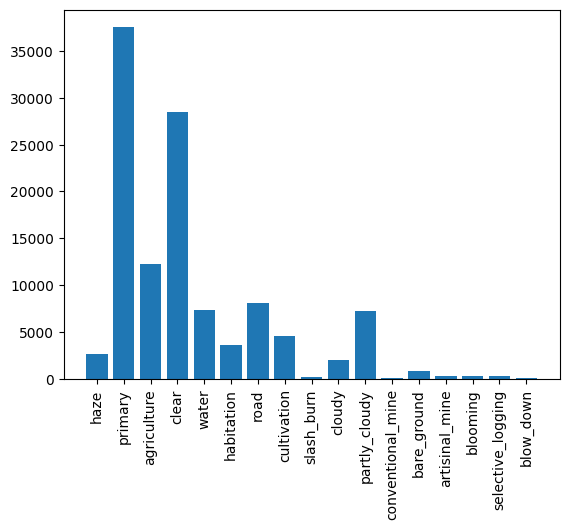

In [35]:
plt.bar(range(len(label_count)), list(label_count.values()), align = 'center')
plt.xticks(range(len(label_count)), list(label_count.keys()), rotation = 90)
plt.show()

# define evaluation metrics set by kaggle compitition

In [36]:
import tensorflow as tf
import keras
from keras import backend as K

def fbeta_K(y_true, y_pred):
    beta_squared = 4
    tp = K.sum(y_true * y_pred) + K.epsilon()
    fp = K.sum(y_pred) - tp
    fn = K.sum(y_true) - tp

    precision = tp/(tp+fp)
    recall = tp/(tp+fn)

    result = (beta_squared + 1) *(precision * recall) / (beta_squared * precision + recall + K.epsilon())
    return result

In [37]:
X_train_files

array(['train_0.jpg', 'train_1.jpg', 'train_2.jpg', ...,
       'train_40476.jpg', 'train_40477.jpg', 'train_40478.jpg'],
      dtype='<U15')

In [38]:
y_train_labels

array(['haze primary', 'agriculture clear primary water', 'clear primary',
       ..., 'agriculture clear primary', 'agriculture clear primary road',
       'agriculture cultivation partly_cloudy primary'], dtype='<U92')

In [39]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
  X_train_files,y_train_labels , random_state=104,test_size=0.25, shuffle=False)

In [40]:
X_val, X_test, y_val, y_test = train_test_split(
  X_val,y_val , random_state=104,test_size=0.5, shuffle=False)

In [41]:
print(f"X Train set:{len(X_train)}")
print(f"y Train set:{len(y_train)}")
print(f"X val set:{len(X_val)}")
print(f"y val set:{len(y_val)}")
print(f"X Test set:{len(X_test)}")
print(f"y Test set:{len(y_test)}")

X Train set:30359
y Train set:30359
X val set:5060
y val set:5060
X Test set:5060
y Test set:5060


## Make temporary dataset

In [42]:
train_df = pd.DataFrame(list(zip(X_train, y_train)), columns = ['image_name', 'tags'])
val_df = pd.DataFrame(list(zip(X_val, y_val)), columns = ['image_name', 'tags'])
test_df = pd.DataFrame(list(zip(X_test, y_test)), columns = ['image_name', 'tags'])

In [43]:
train_df[:10]

,image_name,tags
0,train_0.jpg,haze primary
1,train_1.jpg,agriculture clear primary water
2,train_2.jpg,clear primary
3,train_3.jpg,clear primary
4,train_4.jpg,agriculture clear habitation primary road
5,train_5.jpg,haze primary water
6,train_6.jpg,agriculture clear cultivation primary water
7,train_7.jpg,haze primary
8,train_8.jpg,agriculture clear cultivation primary
9,train_9.jpg,agriculture clear cultivation primary road


In [44]:
train_df['tags'] = train_df['tags'].apply(lambda x: x.split(' '))
val_df['tags'] = val_df['tags'].apply(lambda x: x.split(' '))
test_df['tags'] = test_df['tags'].apply(lambda x: x.split(' '))

# Convert images into arrays

In [45]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale = 1./255,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        horizontal_flip = True,
        vertical_flip = True
    )

train_data_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory = Train_path,
    x_col = 'image_name',
    y_col = 'tags',
    target_size = (256, 256),
    class_mode = 'categorical',
    batch_size = 128,
    classes = labels,
)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale = 1./255
)

val_data_generator = val_datagen.flow_from_dataframe(
    val_df,
    directory = Train_path,
    x_col = 'image_name',
    y_col = 'tags',
    target_size = (256, 256),
    class_mode = 'categorical',
    batch_size = 128,
    classes = labels,
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255
)

test_data_generator = test_datagen.flow_from_dataframe(
    test_df,
    directory=Train_path,
    x_col='image_name',
    y_col='tags',
    target_size=(256,256),
    class_mode='categorical',
    batch_size=128,
    classes=labels,
    shuffle=False,
)


Found 30359 validated image filenames belonging to 17 classes.
Found 5060 validated image filenames belonging to 17 classes.
Found 5060 validated image filenames belonging to 17 classes.


# visualize the data

In [46]:
img, label_tags = train_data_generator.next()

In [47]:
labels

['agriculture',
 'artisinal_mine',
 'bare_ground',
 'blooming',
 'blow_down',
 'clear',
 'cloudy',
 'conventional_mine',
 'cultivation',
 'habitation',
 'haze',
 'partly_cloudy',
 'primary',
 'road',
 'selective_logging',
 'slash_burn',
 'water']

/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


(-0.5, 255.5, 255.5, -0.5)

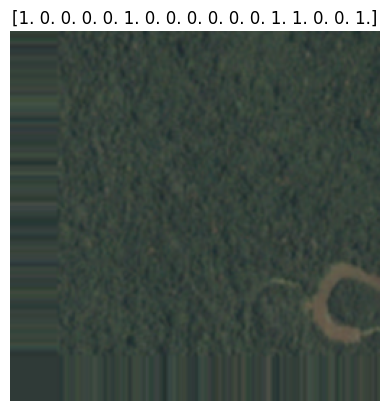

In [48]:
random_int = random.randint(0,128)

plt.figure()
plt.imshow(img[random_int])
plt.title(label_tags[random_int])
plt.axis(False)

#Model_0: CNN Model

### Build first model

In [54]:
model_0 = tf.keras.Sequential([
    Conv2D(32, kernel_size = (3, 3), activation = 'relu',padding = 'same', input_shape = (256,256,3)),
    Conv2D(32, kernel_size = (3, 3), activation = 'relu'),
    MaxPool2D(pool_size = (2, 2)),
    Dropout(0.1),

    Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.1),


    Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.1),

    Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(256, kernel_size=(3, 3), activation='relu'),
    Conv2D(256, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.1),

    Flatten(),

    Dense(labels_len, activation = 'sigmoid')

])

In [56]:
## Compile the model
model_0.compile(loss = 'binary_crossentropy',
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
                metrics = ["accuracy","binary_accuracy",fbeta_K])


In [57]:
model_0.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 conv2d_11 (Conv2D)          (None, 254, 254, 32)      9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 127, 127, 32)      0         
                                                                 
 conv2d_12 (Conv2D)          (None, 127, 127, 64)      18496     
                                                                 
 conv2d_13 (Conv2D)          (None, 125, 125, 64)      36928     
                                                      

In [58]:

model_0.fit(train_data_generator,
            epochs = 13,
            validation_data = val_data_generator,
            workers = 4,
            use_multiprocessing = False,
            max_queue_size = 10)

Epoch 1/13
238/238 [==============================] - 516s 2s/step - loss: 0.2626 - accuracy: 0.0059 - binary_accuracy: 0.9032 - fbeta_K: 0.5593 - val_loss: 0.2257 - val_accuracy: 0.0247 - val_binary_accuracy: 0.9131 - val_fbeta_K: 0.5940
Epoch 2/13
238/238 [==============================] - 516s 2s/step - loss: 0.2117 - accuracy: 0.0334 - binary_accuracy: 0.9171 - fbeta_K: 0.6245 - val_loss: 0.2121 - val_accuracy: 0.0342 - val_binary_accuracy: 0.9202 - val_fbeta_K: 0.6181
Epoch 3/13
238/238 [==============================] - 511s 2s/step - loss: 0.2049 - accuracy: 0.0413 - binary_accuracy: 0.9195 - fbeta_K: 0.6385 - val_loss: 0.2026 - val_accuracy: 0.0391 - val_binary_accuracy: 0.9216 - val_fbeta_K: 0.6326
Epoch 4/13
238/238 [==============================] - 496s 2s/step - loss: 0.1955 - accuracy: 0.0394 - binary_accuracy: 0.9218 - fbeta_K: 0.6542 - val_loss: 0.1904 - val_accuracy: 0.0330 - val_binary_accuracy: 0.9234 - val_fbeta_K: 0.6674
Epoch 5/13
238/238 [========================

In [59]:
model_0.evaluate(val_data_generator)

40/40 [==============================] - 16s 395ms/step - loss: 0.1405 - accuracy: 0.1160 - binary_accuracy: 0.9445 - fbeta_K: 0.7475


[0.14045462012290955,
 0.11600790172815323,
 0.9445362687110901,
 0.7474793791770935]

In [60]:
test_eval = model_0.evaluate(test_data_generator)
test_eval

40/40 [==============================] - 17s 416ms/step - loss: 0.1389 - accuracy: 0.1150 - binary_accuracy: 0.9457 - fbeta_K: 0.7500


[0.13891230523586273,
 0.11501976102590561,
 0.9457103610038757,
 0.7500386238098145]

In [62]:
test_pred = model_0.predict(test_data_generator)
test_pred

40/40 [==============================] - 16s 397ms/step


array([[8.89631331e-01, 1.16029743e-03, 1.31818950e-01, ...,
        2.89084506e-04, 2.12877942e-03, 2.63825297e-01],
       [1.18639596e-01, 3.34574399e-03, 1.00385509e-02, ...,
        2.39202268e-02, 2.50396086e-03, 1.40907764e-01],
       [6.04886748e-02, 1.14528797e-04, 1.06686971e-03, ...,
        8.32453734e-05, 3.00152915e-05, 9.27200243e-02],
       ...,
       [9.32924390e-01, 5.38448105e-04, 2.27478489e-01, ...,
        9.75502408e-05, 4.29483829e-03, 1.18520580e-01],
       [9.02492940e-01, 1.06902774e-02, 4.42657135e-02, ...,
        4.13316349e-03, 3.76231340e-03, 3.48265529e-01],
       [6.33130848e-01, 5.33955172e-03, 2.01561265e-02, ...,
        1.38667384e-02, 2.72003282e-02, 3.87194544e-01]], dtype=float32)

In [63]:
test_pred.shape

(5060, 17)

In [64]:
test_pred[0]

array([8.8963133e-01, 1.1602974e-03, 1.3181895e-01, 4.1483323e-05,
       1.6941753e-04, 8.9878947e-01, 5.1968044e-04, 1.6136880e-03,
       8.4370703e-02, 1.5705320e-01, 2.3872646e-02, 7.4776210e-02,
       9.4486874e-01, 7.5435621e-01, 2.8908451e-04, 2.1287794e-03,
       2.6382530e-01], dtype=float32)

In [65]:
test_images, test_labels = next(iter(test_data_generator))

In [66]:
test_images.shape

(128, 256, 256, 3)

In [67]:
test_labels.shape

(128, 17)

In [68]:
test_images[12]

array([[[0.16470589, 0.21960786, 0.20000002],
        [0.14901961, 0.20784315, 0.18823531],
        [0.12941177, 0.20000002, 0.18431373],
        ...,
        [0.20392159, 0.26666668, 0.2392157 ],
        [0.18823531, 0.2509804 , 0.21960786],
        [0.1764706 , 0.2392157 , 0.20000002]],

       [[0.16862746, 0.21960786, 0.20000002],
        [0.15686275, 0.21568629, 0.19607845],
        [0.14117648, 0.20784315, 0.19215688],
        ...,
        [0.20000002, 0.27058825, 0.23529413],
        [0.18823531, 0.25490198, 0.21960786],
        [0.18039216, 0.24313727, 0.20000002]],

       [[0.17254902, 0.22352943, 0.19607845],
        [0.16862746, 0.227451  , 0.20000002],
        [0.16078432, 0.22352943, 0.20392159],
        ...,
        [0.20000002, 0.27450982, 0.23529413],
        [0.19215688, 0.2627451 , 0.21960786],
        [0.18431373, 0.2509804 , 0.20392159]],

       ...,

       [[0.17254902, 0.23529413, 0.20784315],
        [0.15294118, 0.21960786, 0.19607845],
        [0.14117648, 0

In [69]:
labels

['agriculture',
 'artisinal_mine',
 'bare_ground',
 'blooming',
 'blow_down',
 'clear',
 'cloudy',
 'conventional_mine',
 'cultivation',
 'habitation',
 'haze',
 'partly_cloudy',
 'primary',
 'road',
 'selective_logging',
 'slash_burn',
 'water']

(-0.5, 255.5, 255.5, -0.5)

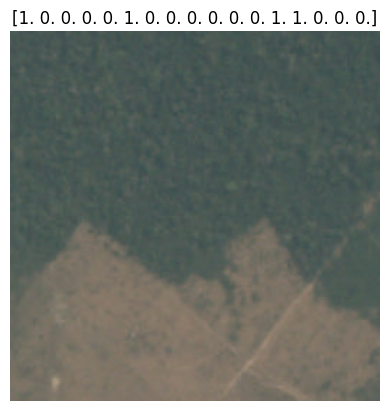

In [103]:
random_int = random.randint(0, 128)

plt.figure()
plt.imshow(test_images[random_int])
plt.title(test_labels[random_int])
plt.axis(False)

In [104]:
sorted(zip(test_labels[random_int], labels), key = lambda pair : pair[0],reverse = True)

[(1.0, 'agriculture'),
 (1.0, 'clear'),
 (1.0, 'primary'),
 (1.0, 'road'),
 (0.0, 'artisinal_mine'),
 (0.0, 'bare_ground'),
 (0.0, 'blooming'),
 (0.0, 'blow_down'),
 (0.0, 'cloudy'),
 (0.0, 'conventional_mine'),
 (0.0, 'cultivation'),
 (0.0, 'habitation'),
 (0.0, 'haze'),
 (0.0, 'partly_cloudy'),
 (0.0, 'selective_logging'),
 (0.0, 'slash_burn'),
 (0.0, 'water')]

In [105]:
test_case_pred = model_0.predict(tf.expand_dims(test_images[random_int], axis = 0))

1/1 [==============================] - 0s 21ms/step


In [106]:
test_case_pred

array([[7.0806640e-01, 2.3596955e-03, 1.7943954e-02, 2.4657068e-04,
        2.5030150e-04, 8.6421889e-01, 3.1123247e-05, 8.1008085e-04,
        1.3361348e-01, 7.7503100e-02, 7.5888574e-02, 6.2553637e-02,
        9.9481010e-01, 3.8166517e-01, 1.6519686e-03, 4.6967850e-03,
        3.4815395e-01]], dtype=float32)

In [107]:
tf.squeeze(test_case_pred)

<tf.Tensor: shape=(17,), dtype=float32, numpy=
array([7.0806640e-01, 2.3596955e-03, 1.7943954e-02, 2.4657068e-04,
       2.5030150e-04, 8.6421889e-01, 3.1123247e-05, 8.1008085e-04,
       1.3361348e-01, 7.7503100e-02, 7.5888574e-02, 6.2553637e-02,
       9.9481010e-01, 3.8166517e-01, 1.6519686e-03, 4.6967850e-03,
       3.4815395e-01], dtype=float32)>

In [108]:
sorted(zip(tf.squeeze(test_case_pred), labels), key = lambda pair : pair[0],reverse = True)

[(<tf.Tensor: shape=(), dtype=float32, numpy=0.9948101>, 'primary'),
 (<tf.Tensor: shape=(), dtype=float32, numpy=0.8642189>, 'clear'),
 (<tf.Tensor: shape=(), dtype=float32, numpy=0.7080664>, 'agriculture'),
 (<tf.Tensor: shape=(), dtype=float32, numpy=0.38166517>, 'road'),
 (<tf.Tensor: shape=(), dtype=float32, numpy=0.34815395>, 'water'),
 (<tf.Tensor: shape=(), dtype=float32, numpy=0.13361348>, 'cultivation'),
 (<tf.Tensor: shape=(), dtype=float32, numpy=0.0775031>, 'habitation'),
 (<tf.Tensor: shape=(), dtype=float32, numpy=0.075888574>, 'haze'),
 (<tf.Tensor: shape=(), dtype=float32, numpy=0.06255364>, 'partly_cloudy'),
 (<tf.Tensor: shape=(), dtype=float32, numpy=0.017943954>, 'bare_ground'),
 (<tf.Tensor: shape=(), dtype=float32, numpy=0.004696785>, 'slash_burn'),
 (<tf.Tensor: shape=(), dtype=float32, numpy=0.0023596955>, 'artisinal_mine'),
 (<tf.Tensor: shape=(), dtype=float32, numpy=0.0016519686>,
  'selective_logging'),
 (<tf.Tensor: shape=(), dtype=float32, numpy=0.0008100